In [1]:
import gurobipy as gp
from gurobipy import GRB
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
import os, pathlib
FILE_DIR = os.getcwd()

# Fuel Types
FUEL = ['geothermal', 'NGCC', 'nuclear', 'hydro', 'wind', 'solar', 'other']
NUMFT = len(FUEL)

# NREL LCA (Life Cycle Assessment) CO2 Emissions in metric tons per MWh for each fuel type 
E = np.array([0.038, 0.49, 0.012, 0.024, 0.012, 0.048, 0.23])
# LCOE in $/MWh for each fuel type from AEO2023
C = np.array([37.30, 42.72, 71.00, 57.12, 31.07, 23.22, 77.16])

# State level data on population, energy demand, current co2 emissions from electricity
FNAME = os.path.join(FILE_DIR, "StateData.xlsx")
STATES = pd.read_excel(FNAME, sheet_name="StateData", index_col=0, header=0)

# CAISO (Aug 2025) installed generation capacity for the state (in MW)
INSTALLED_CAPACITY_MW = {
    'geothermal': 1_900,
    'NGCC': 36_000, # plus imports are 2_160
    'nuclear': 2_300,
    'hydro': 10_000,
    'wind': 6_300,
    'solar': 20_000,
    'other': 8_000
}
INSTALLED_CAPACITY_MW_original = {
    'coal': 20_000,
    'NGCC': 4_600+2_160, # plus imports are 2_160
    'nuclear': 2_300,
    'hydro': 2_600,
    'wind': 4_000,
    'solar': 10_000,
}
INSTALLED_CAPACITY_MW_array = np.array([INSTALLED_CAPACITY_MW[f] for f in FUEL])

In [3]:
### DATA PREPARATION FOR HOURLY MODEL ###

# Number of time steps in our model (24 hours)
T = 24
hours = np.arange(T)

# 1. Simulate the Demand for a representative day
# This curve shows high demand in the morning and a sharp ramp-up in the evening,
# with a dip in the middle of the day.
# Normalize to 1.0 as peak within a day
demand_curve_normalized = np.array([
    0.60, 0.58, 0.57, 0.56, 0.57, 0.61, 0.70, 0.75, # Morning
    0.76, 0.77, 0.77, 0.78, 0.78, 0.80, 0.82, 0.86, # Afternoon
    0.88, 0.9, 0.95, 1.00, 0.98, 0.90, 0.80, 0.70  # Evening Peak
])

duck_curve_normalized_original = np.array([
    0.60, 0.58, 0.57, 0.56, 0.57, 0.61, 0.70, 0.75, # Morning
    0.65, 0.55, 0.45, 0.38, 0.35, 0.33, 0.35, 0.45, # Midday "Belly"
    0.60, 0.80, 0.95, 1.00, 0.98, 0.90, 0.80, 0.70  # Evening Peak
])

# 2. Define Hourly Capacity Factors (AEO2023)
# Solar only works during the day. Wind might be stronger at night.
# Dispatchable generation (Coal, NGCC, Nuclear) is assumed to be available 24/7.
HRLY_CAP_FACTORS = pd.DataFrame(index=FUEL, columns=hours, data=1.0) # Default to 100% available
HRLY_CAP_FACTORS.loc['solar'] = [0, 0, 0, 0, 0, 0, 0.3, 0.3,
                                 0.77, 0.89, 0.96, 1.0, 1.0, 1, 1, 1,
                                 0.96, 0.92, 0.78, 0.3, 0.02, 0, 0, 0]
HRLY_CAP_FACTORS.loc['wind']  = [0.5, 0.52, 0.53, 0.51, 0.48, 0.45, 0.42, 0.43,
                                 0.45, 0.4, 0.35, 0.3, 0.28, 0.30, 0.32, 0.35,
                                 0.4, 0.45, 0.5, 0.55, 0.6, 0.58, 0.55, 0.52]


# 3. Define Battery Bank Parameters
EVC_MAX = 80/1e3 # convert to MWh
EVS = 1.08e6 # Summation of all counties in service area from predictive model (15087)
BATTERY_MAX_ENERGY_MWH = EVC_MAX*EVS
BATTERY_MAX_POWER_MW = BATTERY_MAX_ENERGY_MWH / 4 # Max charge/discharge rate (C/4 rate)
BATTERY_CHARGE_EFFICIENCY = 0.95 # 95% efficiency when charging
BATTERY_INITIAL_SOC_MWH = BATTERY_MAX_ENERGY_MWH / 2 # Start the day at 50% charge

# 4. Define Optimization Parameters
state = 'CA'
futureDemandGrowth = 1.0 # Future electricity demand as pct of current
futureCo2Improve = 3 # Future emissions target as pct of current

daily_demand_mwh = STATES['Demand (MWh)'][state] * futureDemandGrowth / 365
HRLYDEMAND = demand_curve_normalized * daily_demand_mwh / demand_curve_normalized.sum()
daily_co2_limit = STATES['CO2 Emissions (million metric tons)'][state]*1e6*futureCo2Improve/365

In [4]:
(HRLY_CAP_FACTORS.loc['wind'] * INSTALLED_CAPACITY_MW['wind']).sum()

67662.0

In [5]:
### --- OPTIMIZATION MODEL WITH BATTERIES --- ###

# Initialize the model
# Set up Gurobi environment
env = gp.Env(empty=True)
env.setParam('OutputFlag', 0)
env.start()

# Initialize the model
m = gp.Model(env=env, name="Hourly_Energy_Dispatch_with_Battery")

### DECISION VARIABLES ###

# generation[i, t]: kWh generated by fuel i in hour t
generation = m.addMVar((NUMFT, T), vtype=GRB.CONTINUOUS, name="generation")

# charge[t]: kWh sent TO the battery in hour t
charge = m.addMVar(T, vtype=GRB.CONTINUOUS, ub=BATTERY_MAX_POWER_MW, name="charge")

# discharge[t]: kWh sent FROM the battery in hour t
discharge = m.addMVar(T, vtype=GRB.CONTINUOUS, ub=BATTERY_MAX_POWER_MW, name="discharge")

# soc[t]: State of Charge (energy in kWh) of the battery at the END of hour t
soc = m.addMVar(T, vtype=GRB.CONTINUOUS, lb=0, ub=BATTERY_MAX_ENERGY_MWH, name="soc")


### OBJECTIVE FUNCTION ###
# Minimize the total cost of generation over the 24-hour period
m.setObjective(gp.quicksum(generation[i, t] * C[i] for i in range(NUMFT) for t in range(T)), GRB.MINIMIZE)


### CONSTRAINTS ###

# 1. Hourly Demand Fulfillment Constraint
# For each hour, total generation + battery discharge - battery charge must equal demand.
m.addConstrs((generation.sum(axis=0)[t] + discharge[t] - charge[t] == HRLYDEMAND[t] for t in range(T)), name="DemandFulfillment")

# 2. Generation Capacity Constraint
# Each generator's output in an hour cannot exceed its installed capacity * its hourly capacity factor.
m.addConstrs((generation[i, t] <= INSTALLED_CAPACITY_MW_array[i] * HRLY_CAP_FACTORS.loc[FUEL[i], t] for i in range(NUMFT) for t in range(T)), name="GenCapacity")

# 3. Total CO2 Emissions Constraint
# Sum of all emissions over 24 hours must be below the daily limit.
m.addConstr(gp.quicksum(generation[i, t] * E[i] for i in range(NUMFT) for t in range(T)) <= daily_co2_limit, name="CO2_Limit")

# --- BATTERY CONSTRAINTS ---

# 4. Battery State of Charge (SoC) Evolution
# This is the key constraint linking time periods.
# SoC at end of hour t = SoC at end of hour t-1 + energy charged - energy discharged.
m.addConstr(soc[0] == BATTERY_INITIAL_SOC_MWH + charge[0] * BATTERY_CHARGE_EFFICIENCY - discharge[0], name="SoC_Initial")
m.addConstrs((soc[t] == soc[t-1] + charge[t] * BATTERY_CHARGE_EFFICIENCY - discharge[t] for t in range(1, T)), name="SoC_Evolution")

# 5. Cyclic Constraint
# Ensure the battery has at least as much energy at the end of the day as it started with.
m.addConstr(soc[T-1] >= BATTERY_INITIAL_SOC_MWH, name="CyclicSoC")

### SOLVE THE MODEL ###
m.optimize()
m.write("15066_final_5A_timevariant.lp") # Write model to file

Optimal daily cost: $22,625,640


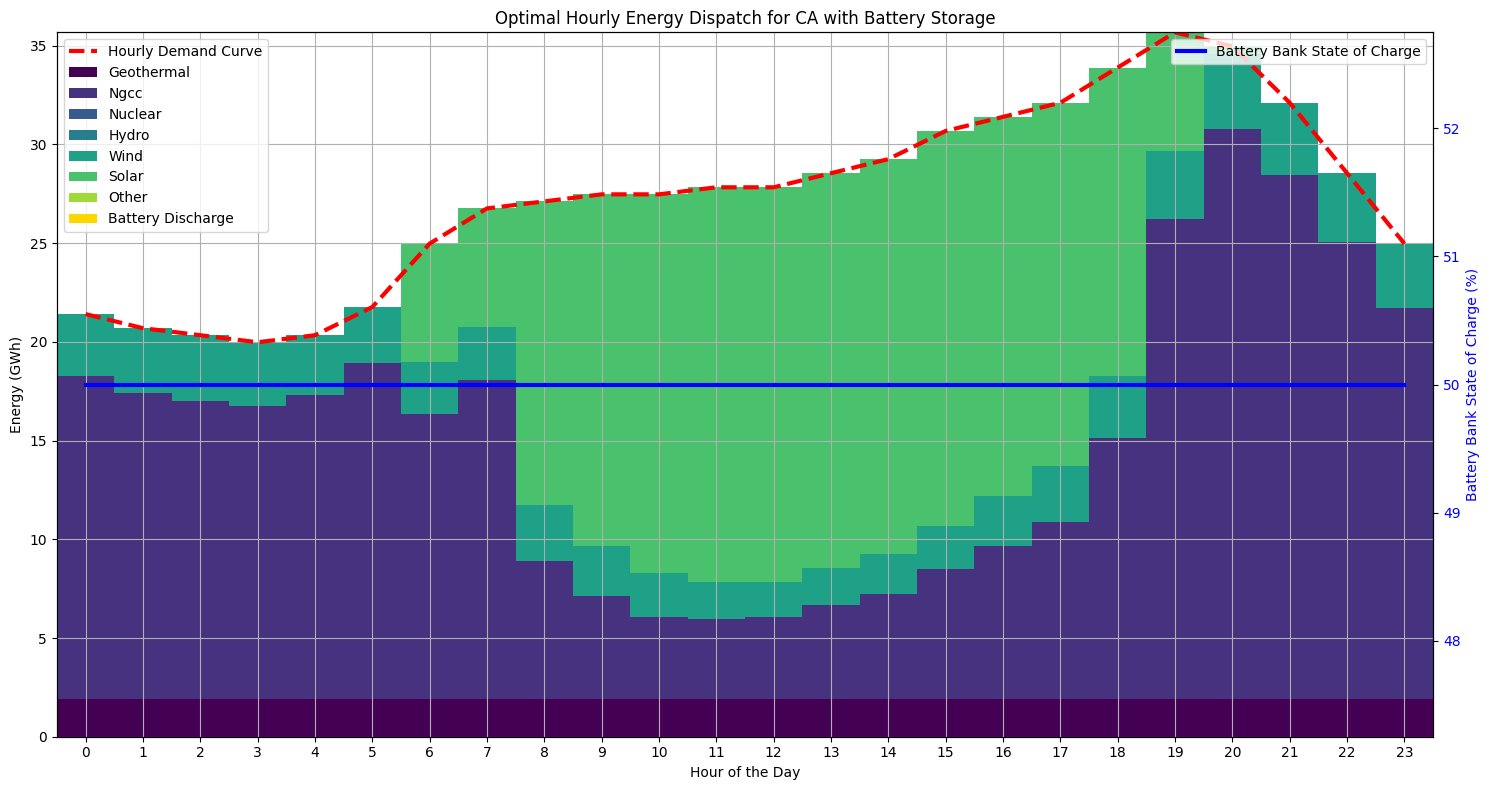

In [6]:
### VISUALIZE THE RESULTS ###

if m.Status == GRB.OPTIMAL:
    print(f"Optimal daily cost: ${m.ObjVal:,.0f}")

    # Extract solution data, convert MWh to GWh
    gen_sol = pd.DataFrame(generation.X, index=FUEL, columns=hours)/1e3
    charge_sol = charge.X/1e3
    discharge_sol = discharge.X/1e3
    soc_sol = soc.X
    
    # Create the plot
    fig, ax1 = plt.subplots(figsize=(15, 8))
    
    # Plot net demand (the duck curve)
    ax1.plot(hours, HRLYDEMAND/1e3, 'r--', linewidth=3, label='Hourly Demand Curve')

    # Stacked bar chart for generation
    bottom = np.zeros(T)
    colors = plt.cm.viridis(np.linspace(0, 1, NUMFT+1))
    for i, fuel in enumerate(FUEL):
        ax1.bar(hours, gen_sol.loc[fuel], bottom=bottom, label=fuel.capitalize(), color=colors[i], width=1.0)
        bottom += gen_sol.loc[fuel]
    # Plot battery discharge (adds to supply)
    ax1.bar(hours, discharge_sol, bottom=bottom, label='Battery Discharge', color='gold', width=1.0)

    ax1.set_xlabel('Hour of the Day')
    ax1.set_ylabel('Energy (GWh)')
    ax1.set_title(f'Optimal Hourly Energy Dispatch for {state} with Battery Storage')
    ax1.legend(loc='upper left')
    ax1.grid(True)
    ax1.set_xticks(hours)
    ax1.set_xlim(-0.5, 23.5)

    # Create a second y-axis for the battery State of Charge
    ax2 = ax1.twinx()
    # Plot battery charge (negative value to show it's a load)
    # ax2.plot(hours, -charge_sol, 'm-.', linewidth=2, label='Battery Charge')
    # Plot State of Charge
    ax2.plot(hours, soc_sol/BATTERY_MAX_ENERGY_MWH*100, 'b-', linewidth=3, label='Battery Bank State of Charge')
    # ax2.plot(hours, HRLY_CAP_FACTORS['solar'], 'b-', linewidth=3, label='')

    ax2.set_ylabel('Battery Bank State of Charge (%)', color='b')
    ax2.tick_params(axis='y', labelcolor='b')
    ax2.legend(loc='upper right')
    
    fig.tight_layout()
    plt.show()

else:
    print("Optimization was not successful. Status:", m.Status)

Optimal daily cost: $22,625,640


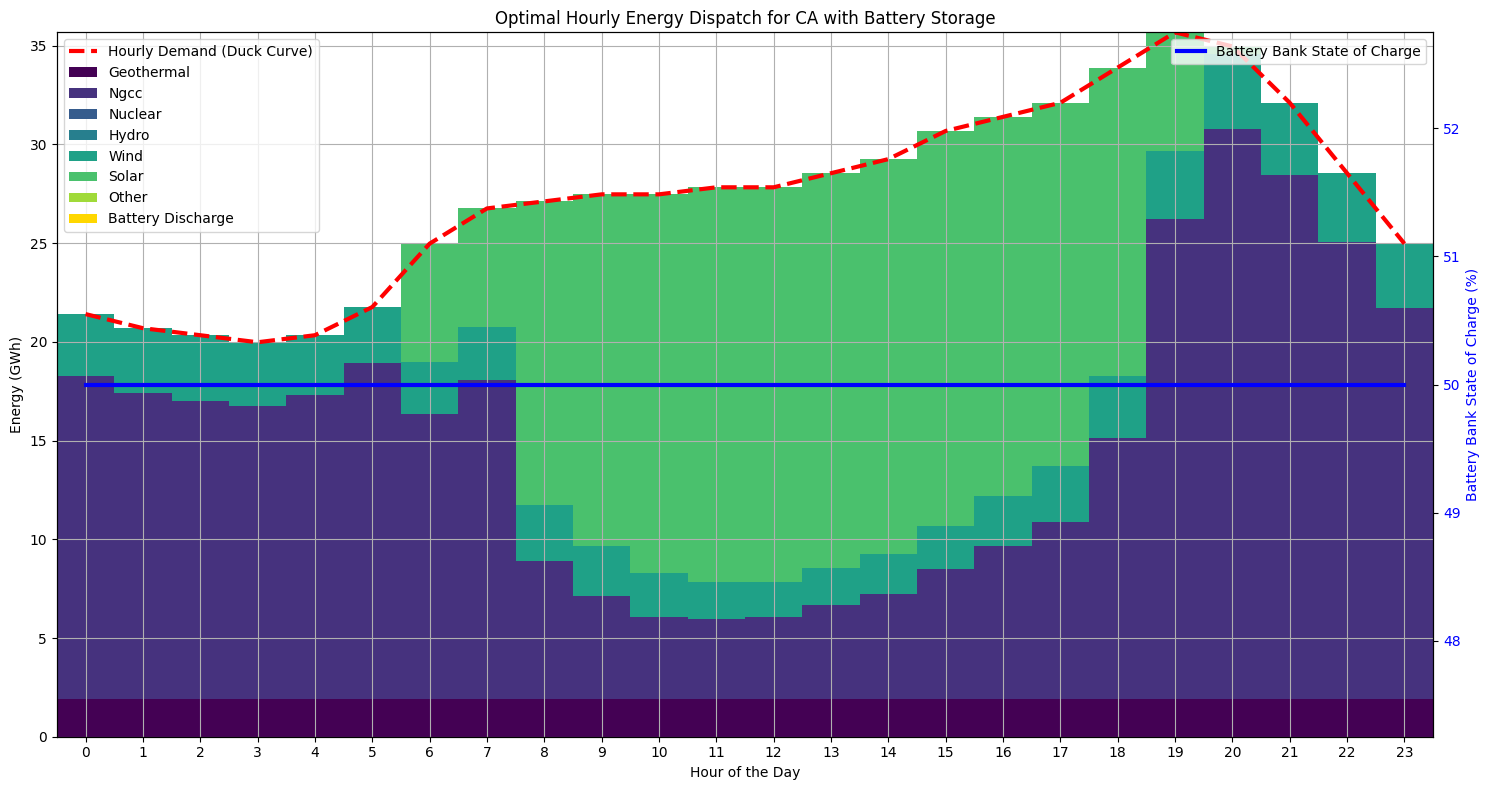

In [7]:
# m.getConstrByName('Const2').setAttr('RHS', )
m.update()
m.optimize()

### VISUALIZE THE RESULTS ###

if m.Status == GRB.OPTIMAL:
    print(f"Optimal daily cost: ${m.ObjVal:,.0f}")

    # Extract solution data, convert MWh to GWh
    gen_sol = pd.DataFrame(generation.X, index=FUEL, columns=hours)/1e3
    charge_sol = charge.X/1e3
    discharge_sol = discharge.X/1e3
    soc_sol = soc.X
    
    # Create the plot
    fig, ax1 = plt.subplots(figsize=(15, 8))
    
    # Plot net demand (the duck curve)
    ax1.plot(hours, HRLYDEMAND/1e3, 'r--', linewidth=3, label='Hourly Demand (Duck Curve)')

    # Stacked bar chart for generation
    bottom = np.zeros(T)
    colors = plt.cm.viridis(np.linspace(0, 1, NUMFT+1))
    for i, fuel in enumerate(FUEL):
        ax1.bar(hours, gen_sol.loc[fuel], bottom=bottom, label=fuel.capitalize(), color=colors[i], width=1.0)
        bottom += gen_sol.loc[fuel]
    # Plot battery discharge (adds to supply)
    ax1.bar(hours, discharge_sol, bottom=bottom, label='Battery Discharge', color='gold', width=1.0)

    ax1.set_xlabel('Hour of the Day')
    ax1.set_ylabel('Energy (GWh)')
    ax1.set_title(f'Optimal Hourly Energy Dispatch for {state} with Battery Storage')
    ax1.legend(loc='upper left')
    ax1.grid(True)
    ax1.set_xticks(hours)
    ax1.set_xlim(-0.5, 23.5)

    # Create a second y-axis for the battery State of Charge
    ax2 = ax1.twinx()
    # Plot battery charge (negative value to show it's a load)
    # ax2.plot(hours, -charge_sol, 'm-.', linewidth=2, label='Battery Charge')
    # Plot State of Charge
    ax2.plot(hours, soc_sol/BATTERY_MAX_ENERGY_MWH*100, 'b-', linewidth=3, label='Battery Bank State of Charge')
    # ax2.plot(hours, HRLY_CAP_FACTORS['solar'], 'b-', linewidth=3, label='')

    ax2.set_ylabel('Battery Bank State of Charge (%)', color='b')
    ax2.tick_params(axis='y', labelcolor='b')
    ax2.legend(loc='upper right')
    
    fig.tight_layout()
    plt.show()

else:
    print("Optimization was not successful. Status:", m.Status)